# This purpose of this project is to compare the performance of kshape vs Kmeans on a time series dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [99]:
from sklearn.cluster import DBSCAN

# ECGFiveDays

Data are from a 67 year old male. The two classes correspond to two dates that the ECG was recorded, which are five days apart: 12/11/1990 and 17/11/1990.

Train size: 23

Test size: 861

Missing value: No

Number of classses: 2

Time series length: 136

Data donated by Yanping Chen and Eamonn Keogh (see [1]).

[1] http://www.timeseriesclassification.com/description.php?Dataset=ECGFiveDays

In [4]:
ecg5_train = pd.read_csv("UCRArchive_2018/ECGFiveDays/ECGFiveDays_TRAIN.tsv", sep='\t', header=None)
ecg5_test = pd.read_csv("UCRArchive_2018/ECGFiveDays/ECGFiveDays_TEST.tsv", sep='\t', header=None)

ecg5_train.rename(columns={0:"Class"}, inplace=True)
ecg5_test.rename(columns={0:"Class"}, inplace=True)

In [5]:
X_train = to_time_series_dataset(ecg5_train.iloc[:, 1:])
y_train = ecg5_train["Class"].astype(int)

X_test = to_time_series_dataset(ecg5_test.iloc[:, 1:])
y_test = ecg5_test["Class"].astype(int)

In [6]:
# Basic summary statistics
print("Number of time series:", len(ecg5_train))
print("Number of unique classes:", len(np.unique(ecg5_train.iloc[:, 0])))
print("Time series length:", len(ecg5_train.iloc[0, 1:]))

Number of time series: 23
Number of unique classes: 2
Time series length: 136


In [7]:
ecg5_train.head()

,Class,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
0,1,0.009913,0.033429,-0.005764,-0.029279,-0.052795,0.009913,-0.021441,-0.029279,-0.060633,...,-0.091987,0.002075,-0.044956,-0.060633,-0.068472,0.002075,-0.029279,-0.115503,0.002075,0.025590
1,1,0.073039,0.032245,0.040404,0.048563,0.032245,0.052642,0.040404,0.015928,0.015928,...,-0.371614,-0.371614,-0.420566,-0.363455,-0.387931,-0.387931,-0.404249,-0.387931,-0.375693,-0.404249
2,2,1.908786,0.368965,0.340811,0.322041,0.350195,0.350195,0.378350,0.331426,0.378350,...,-0.062731,-0.081500,0.021731,0.153117,0.143732,0.331426,0.002962,-0.297348,-0.278579,-0.353656
3,2,-0.480461,-0.470177,-0.377624,-0.429042,-0.429042,-0.449610,-0.377624,-0.315922,-0.449610,...,-0.110247,-0.233652,-0.336489,-0.408475,-0.583298,-0.511312,-0.387908,-0.367340,-0.377624,-0.367340
4,1,0.335308,0.298158,0.298158,0.288870,0.307445,0.223857,0.242432,0.261008,0.158844,...,-0.305533,-0.379834,-0.333396,-0.351971,-0.324108,-0.314821,-0.351971,-0.324108,-0.379834,-0.407696


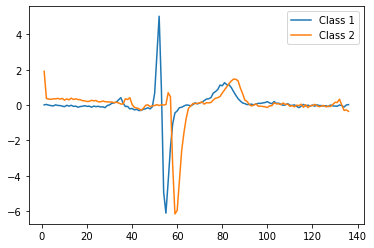

In [8]:
ecg5_train.T[0][1:].plot()
ecg5_train.T[2][1:].plot()
plt.legend(["Class 1", "Class 2"])
plt.show()

The plots are noisy with distortions. There are also differences in
amplitude, period, phase shift, and vertical shift that make classification a
challenge

To the naked, untrained eye, the examples from class 1.0 and class 2.0 seem
indistinguishable

# Training

In [9]:
# Prepare the data - Scale
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

# k-shape
    Group time series based on the shape similarity, regardless of the phase and amplitude.

In [10]:
# Train using k-Shape
ks = KShape(n_clusters=2, max_iter=100, n_init=100,verbose=0)
ks.fit(X_train)

KShape(n_clusters=2, n_init=100, verbose=0)

# Evaluation

### Adjusted Rand index: 
a measure of the similarity between two data clusterings adjusted for the chance grouping of elements. This is related to the accuracy measure.

Rand index measures the number of agreements in cluster assignments between the predicted clusterings and the true clusterings. 

Adjusted Rand Index close to 0: Purely randomly assigning clusters

Adjusted Rand Index close to 1: Predicted clusterings match the true clusterings exactly

In [13]:
# Trainset
y_pred = ks.predict(X_train)
ars = adjusted_rand_score(ecg5_train.iloc[:, 0], y_pred)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.668041237113402


In [14]:
# Testset
y_pred = ks.predict(X_test)
ars = adjusted_rand_score(ecg5_test.iloc[:, 0], y_pred)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.34877086125298334


A much better Adjusted Rand Index could be achieved if we have more data in the trainset.

# ECG5000

The original data set for *ECG5000* is a 20-hour long ECG downloaded from Physionet_ATM [1]. The database is BIDMC Congestive Heart Failure Database(chfdb) and the record is chf07. It was originally published by Goldberger et al. [2]. The data were pre-processed in two steps, first extracting each heartbeat and then making each heartbeat equal length using interpolation. These data were originally used by Chen et al. [3]. After that, 5000 heartbeats were randomly selected to make the current data set. Data were from a patient who has severe congestive heart failure. The class values were obtained by automated annotation.

Train size: 500

Test size: 4500

Missing value: No

Number of classses: 5

Time series length: 140

Data donated by Yanping Chen and Eamonn Keogh (see [3], [4]).

[1] https://physionet.org/cgi-bin/atm/ATM

[2] Goldberger, Ary L., et al. "PhysioBank, PhysioToolkit, and PhysioNet: components of a new research resource for complex physiologic signals." Circulation 101.23 (2000): e215-e220.

[3] Chen, Yanping, et al. "A general framework for never-ending learning from time series streams." Data Mining and Knowledge Discovery 29.6 (2015): 1622-1664.

[4] http://www.timeseriesclassification.com/description.php?Dataset=ECG5000

In [29]:
ecg5000_train = pd.read_csv("UCRArchive_2018/ECG5000/ECG5000_TRAIN.tsv", sep='\t', header=None)
ecg5000_test = pd.read_csv("UCRArchive_2018/ECG5000/ECG5000_TEST.tsv", sep='\t', header=None)

ecg5000_train.rename(columns={0:"Class"}, inplace=True)
ecg5000_test.rename(columns={0:"Class"}, inplace=True)

In [30]:
ecg5000_train.shape, ecg5000_test.shape

((500, 141), (4500, 141))

In [32]:
df = pd.concat([ecg5000_train, ecg5000_test])
ecg5000_train, ecg5000_test = train_test_split(df, test_size=0.2, random_state=2019)

In [36]:
X_train = to_time_series_dataset(ecg5000_train.iloc[:, 1:])
y_train = ecg5000_train["Class"].astype(int)

X_test = to_time_series_dataset(ecg5000_test.iloc[:, 1:])
y_test = ecg5000_test["Class"].astype(int)

In [37]:
# Basic summary statistics
print("Number of time series:", len(ecg5000_train))
print("Number of unique classes:", len(np.unique(ecg5000_train.iloc[:, 0])))
print("Time series length:", len(ecg5000_train.iloc[0, 1:]))

Number of time series: 4000
Number of unique classes: 5
Time series length: 140


In [38]:
ecg5000_train.head()

,Class,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
3977,2,-0.872004,-1.737934,-2.179271,-2.621595,-2.743221,-2.848696,-2.642509,-2.144997,-1.699626,...,-0.961985,-1.630911,-2.319958,-3.071662,-3.630929,-3.661980,-3.081851,-1.974048,-0.871374,0.153755
129,1,-0.853866,-2.489415,-3.646334,-4.258130,-3.694179,-2.691938,-2.002917,-1.726384,-0.868932,...,0.826330,1.113123,0.942545,0.852835,0.636228,0.502006,0.475788,0.732305,1.424129,0.387357
2421,1,0.077462,-2.209479,-3.535134,-4.665829,-4.281586,-3.217774,-2.010526,-1.510237,-1.312390,...,0.842265,1.233373,0.865505,0.793086,0.442236,-0.134369,-0.003038,0.472147,0.978863,-0.661881
3858,2,-0.398234,-1.604322,-2.574263,-3.281971,-3.160282,-2.788319,-2.166766,-1.534808,-1.046323,...,0.113387,0.144475,-0.057813,-0.722754,-1.491745,-1.998754,-2.649831,-3.611137,-4.374202,-3.979222
411,2,0.611928,0.282954,0.351850,0.455352,0.372982,0.199899,0.119206,0.146036,0.184410,...,0.282043,0.234917,0.164288,0.216272,0.346861,0.305872,0.047970,-0.051511,0.451866,1.474301


In [8]:
sample_from_each_class = [ecg5000_train[ecg5000_train.Class == i].sample().index[0] for i in range(1, 6)]
sample_from_each_class

[98, 402, 477, 482, 498]

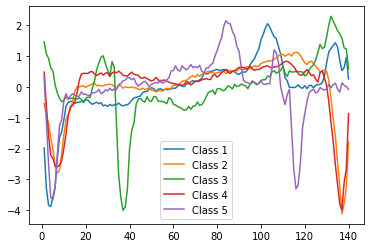

In [10]:
plt.plot(ecg5000_train.T[98][1:])
plt.plot(ecg5000_train.T[402][1:])
plt.plot(ecg5000_train.T[477][1:])
plt.plot(ecg5000_train.T[482][1:])
plt.plot(ecg5000_train.T[498][1:])
plt.legend(["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
plt.show()

In [40]:
ecg5000_train['Class'].value_counts(normalize=True) * 100

1    58.175
2    35.575
4     3.900
3     1.875
5     0.475
Name: Class, dtype: float64

# Training

In [41]:
# Prepare the data - Scale
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

In [42]:
# Train using k-Shape
ks = KShape(n_clusters=5, max_iter=100, n_init=10, verbose=0, random_state=2019)
ks.fit(X_train)

KShape(n_clusters=5, n_init=10, random_state=2019, verbose=0)

# Evaluation

In [43]:
# Trainset
y_pred = ks.predict(X_train)
ars = adjusted_rand_score(ecg5000_train.iloc[:, 0], y_pred)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.5553639462811412


In [44]:
# Testset
y_pred_test = ks.predict(X_test)
ars = adjusted_rand_score(ecg5000_test.iloc[:, 0], y_pred_test)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.5301670526070555


In [50]:
homogeneity = ecg5000_test.copy()
homogeneity['y_pred_test'] = y_pred_test

In [63]:
for i in range(1, 6):
    class_ = homogeneity[homogeneity.Class == i]
    print(f"Homogeneity of class {i}")
    print(class_.loc[:, 'y_pred_test'].value_counts()/len(class_) * 100)
    print('')

Homogeneity of class 1
4    74.662162
3    21.959459
1     3.040541
2     0.337838
Name: y_pred_test, dtype: float64

Homogeneity of class 2
1    57.267442
0    36.918605
2     5.232558
3     0.290698
4     0.290698
Name: y_pred_test, dtype: float64

Homogeneity of class 3
0    42.857143
4    19.047619
1    14.285714
3    14.285714
2     9.523810
Name: y_pred_test, dtype: float64

Homogeneity of class 4
2    47.368421
1    23.684211
0    15.789474
4     7.894737
3     5.263158
Name: y_pred_test, dtype: float64

Homogeneity of class 5
2    60.0
0    20.0
3    20.0
Name: y_pred_test, dtype: float64



Although ARIs have improved by using a larger trainset, it's performance still varies significantly. 

In [64]:
# Train using k-Shape
ks = KShape(n_clusters=5, max_iter=100, n_init=10, verbose=0, random_state=2000)
ks.fit(X_train)

KShape(n_clusters=5, n_init=10, random_state=2000, verbose=0)

In [65]:
# Trainset
y_pred = ks.predict(X_train)
ars = adjusted_rand_score(ecg5000_train.iloc[:, 0], y_pred)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.7331781033218951


In [66]:
# Testset
y_pred = ks.predict(X_test)
ars = adjusted_rand_score(ecg5000_test.iloc[:, 0], y_pred)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.7245987448244717


By altering its random seed, the performance on testset drastically changed.

# KMeans

In [68]:
ecg5000_train = pd.read_csv("UCRArchive_2018/ECG5000/ECG5000_TRAIN.tsv", sep='\t', header=None)
ecg5000_test = pd.read_csv("UCRArchive_2018/ECG5000/ECG5000_TEST.tsv", sep='\t', header=None)

ecg5000_train.rename(columns={0:"Class"}, inplace=True)
ecg5000_test.rename(columns={0:"Class"}, inplace=True)

In [69]:
df = pd.concat([ecg5000_train, ecg5000_test])
ecg5000_train, ecg5000_test = train_test_split(df, test_size=0.2, random_state=2019)

In [74]:
X_train = ecg5000_train.drop('Class', axis=1)
y_train = ecg5000_train['Class']

X_test = ecg5000_test.drop('Class', axis=1)
y_test = ecg5000_test['Class']

In [81]:
# Train using Time Series k-Means
km = TimeSeriesKMeans(n_clusters=5, max_iter=100, n_init=100, metric="euclidean", random_state=2019)
km.fit(X_train)

TimeSeriesKMeans(max_iter=100, n_clusters=5, n_init=100, random_state=2019)

In [92]:
# Predict on training set and evaluate using adjusted Rand index
y_pred_train = km.predict(to_time_series_dataset(X_train))
ars = adjusted_rand_score(ecg5000_train.iloc[:, 0], y_pred_train)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.5063464656715959


In [93]:
# Predict on test set and evaluate using adjusted Rand index
y_pred_test = km.predict(to_time_series_dataset(X_test))
ars = adjusted_rand_score(ecg5000_test.iloc[:, 0], y_pred_test)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.4864981997585834
